<a href="https://colab.research.google.com/github/jhwaffles/cgm_peak_detection/blob/main/cgm_peak_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGM Peak Classification

## Background and Purpose
Continuous Glucose Monitors are wearable devices that help users get real time insights into their blood glucose levels, baselines, how it responds to meals, exercise, etc. These insights are especially helpful for diabetic patients or other patients that have conditions related to blood glucose levels.

There are many personal health applications for collected data. If the data quality is good, one can build models to model glucose peak responses to events such as meals and exercises. However, data is inherently messy in different ways. One major challenge is adherence, having users log their meals timely and accurately, specify the correct time etc. It is common for users to miss logging their meals, or mislog times, which makes it difficult to analyze data downstream.

This analysis implements machine learning and classification (logistic regression) on a collection of annotated peak data. Here is an example of what glucose peaks look like in CGM data.

![example_peaks](![Glucose Peak Detection](https://raw.githubusercontent.com/jhwaffles/cgm_peak_detection/main/good_peaks.png))

For more details on how the peaks were extracted from cgm data, refer to 'peak_detection.ipynb.' The training set includes peak data and peak features extracted from raw cgm files, and contains features:

- glucose max
- glucose min
- glucose area under the curve (AUC)
- max glucose rate of rise
- max glucose rate of fall  
- meal time category
- annotated true post-meal peak (1) or non-meal peak (0)

The goal is to train a classifier to be able to distinguish post-meal peaks (1) vs peaks from non-meal peaks (0).

One possible applications of such classifier would be for the algorithm/software to notify users if a peak was identified, but unlogged after a certain time window (say 2 hours). Users would be reminded to log their meals. Generally a user can remember their meal for a certain window, and this application would help improve adherence to logging data.

Another possible application of such a classifier would be use in personalized medicine. By learning the decision boundary for a user's post-meal peaks and non-meal peaks, it is learning coefficients that relate to a user's physiological system (glucose, insulin, etc) and from this personal recommendations can be made.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

## Data preprocessing

In [4]:
df=pd.read_csv('users_event_features_annotated.csv')
drop_columns=['Unnamed: 0','event_time','event_note','window_start','window_end']
df_filtered=df.drop(columns=drop_columns) #filter out unnecessary columns.
df_filtered=pd.get_dummies(df_filtered, columns=['meal_time_category'], prefix='time', drop_first=True)
df_filtered.head()

FileNotFoundError: [Errno 2] No such file or directory: 'users_event_features_annotated.csv'

### Exploratory Data Analysis

In [ ]:
df_filtered.groupby('Meal').count()

,glucose_max,glucose_min,glucose_auc,glucose_rate_rise,glucose_rate_fall,time_1,time_2,time_3,time_4
Meal,,,,,,,,,
0,34,34,34,34,34,34,34,34,34
1,64,64,64,64,64,64,64,64,64


In [ ]:
df_filtered.groupby('Meal').agg(['mean', 'std', 'median'])

glucose_max                   glucose_min                   glucose_auc  \
            mean        std median        mean        std median        mean   
Meal                                                                           
0     109.705882  21.995219  109.0   88.000000  14.547727   85.5   10.631863   
1     144.890625  26.205608  141.5   93.140625  11.974665   95.0   45.840755   

                         glucose_rate_rise  ... time_1    time_2            \
            std   median              mean  ... median      mean       std   
Meal                                        ...                              
0     12.559450   4.6875         35.928640  ...    0.0  0.205882  0.410426   
1     37.462408  32.6875         92.765625  ...    0.0  0.156250  0.365963   

               time_3                     time_4                   
     median      mean       std median      mean       std median  
Meal                                                               
0       0.0  0.147059  0.359491    0.0  0.235294  0.430562    0.0  
1       0.0  0.312500  0.467177    0.0  0.000000  0.000000    0.0  

[2 rows x 27 columns]

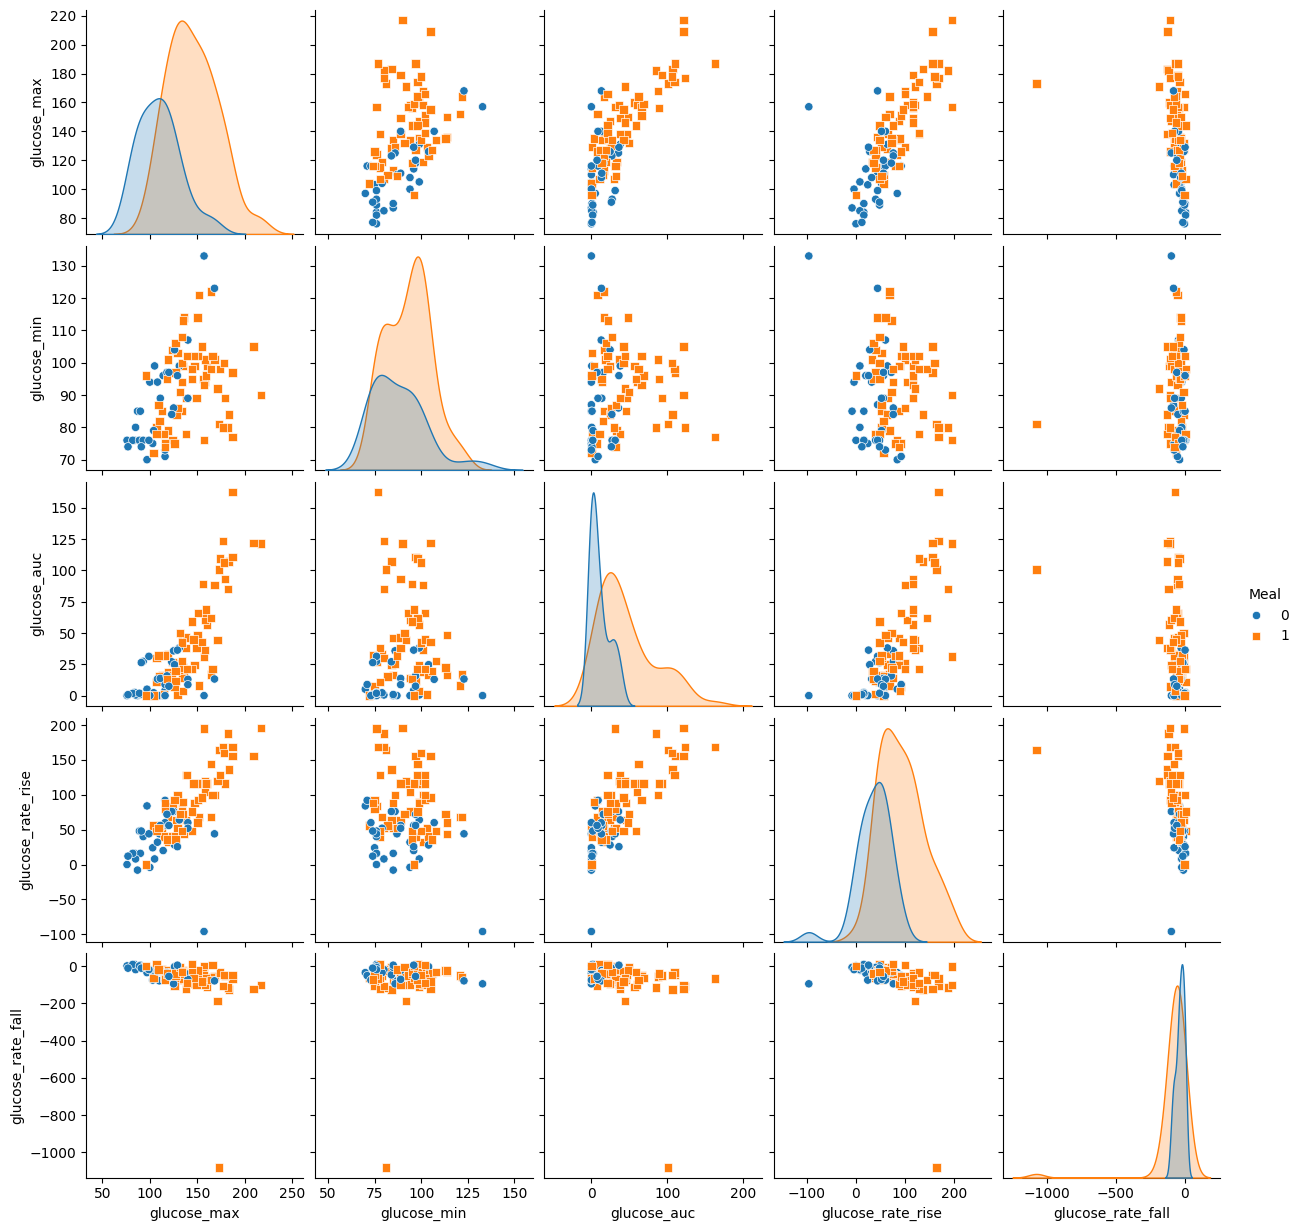

In [ ]:
pairplot_vars=['glucose_max','glucose_min','glucose_auc','glucose_rate_rise','glucose_rate_fall']
sns.pairplot(df_filtered,x_vars=pairplot_vars, y_vars=pairplot_vars, hue='Meal', markers=["o", "s"])

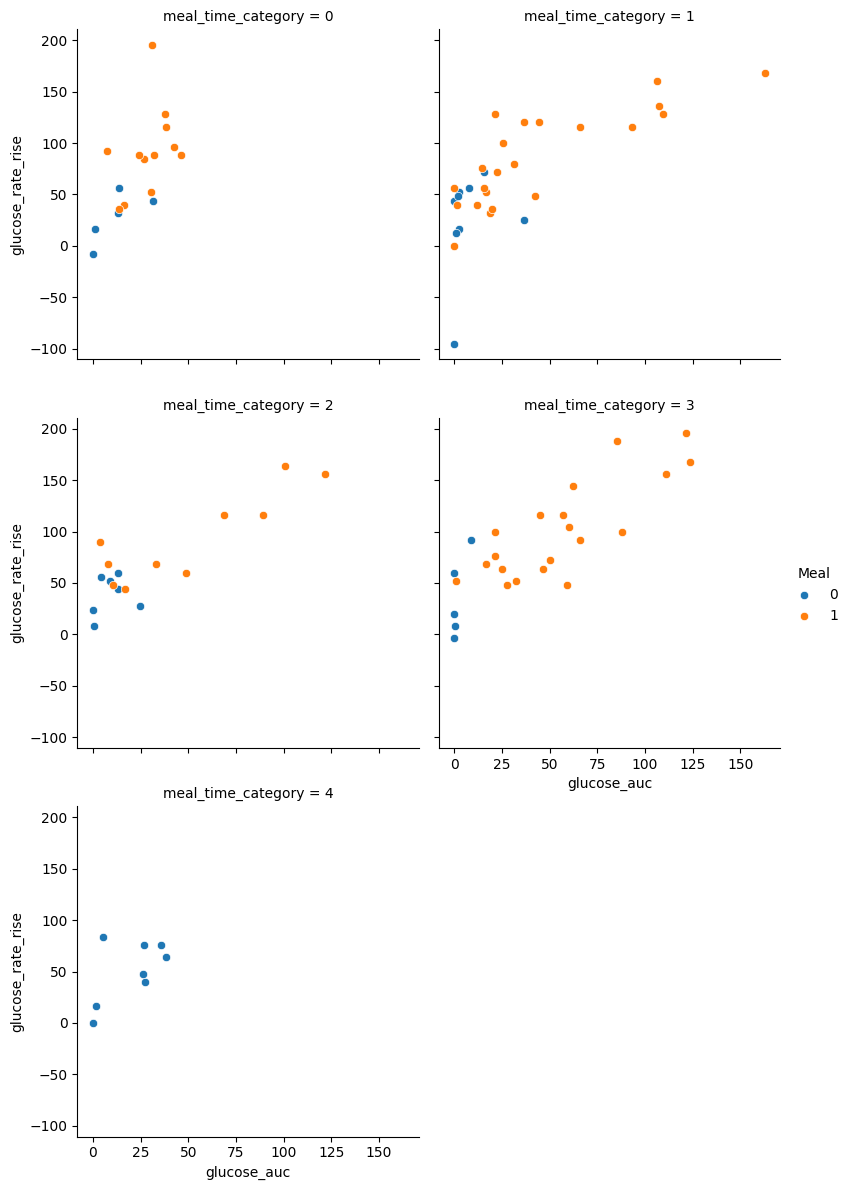

In [ ]:
g = sns.FacetGrid(df, col="meal_time_category", hue="Meal", col_wrap=2, height=4)
g.map(sns.scatterplot, "glucose_auc", "glucose_rate_rise")
g.add_legend()

### Exploratory Data Analysis and Observations:
- More instances of post-meal peaks vs non-meal peaks.
- Distribution wise, the actual post-meal peaks (1) have ranges shifted up in higher glucose_max, glucose_auc, glucose_rate_rise, compared to non-meal peaks (0).
- Distribution wise, post-meal peaks (1) cover the same ranges as non-meal peaks (0) for glucose_min, but post-meal peaks are weighted more to higher values within that range.
- Generally there are distinct groupings in the pairplots. We can likely get good results in classification.
- Meal time category 4 is a good way to separate classes. All peaks in time category 4 are non-meal peaks (0). This makes sense as its less likely for users to eat in the twilight hours.

- Also there are two outliers we want to examine.
    - outlier 1: one has a glucose rate fall of -1000. upon examination this looks like an artifact where there was heavy oscillation in the reading. see outlier1.png we can discard this.
    
    - outlier 2: one has a negative glucose_rate_rise. upon examination this happens where the sensor cut off (technical issue/disconnection). see outlier2.png. we can also discard this.**bold text**

In [ ]:
df[df['glucose_rate_fall']<-1000]

,Unnamed: 0,event_time,event_note,window_start,window_end,glucose_max,glucose_min,glucose_auc,glucose_rate_rise,glucose_rate_fall,meal_time_category,Meal
29,29.0,2024-09-16 15:27:00,NaN,2024-09-16 15:27:00,2024-09-16 17:27:00,173.0,81.0,100.791667,164.0,-1080.0,2,1


In [ ]:
df[df['glucose_rate_rise']<-10]

,Unnamed: 0,event_time,event_note,window_start,window_end,glucose_max,glucose_min,glucose_auc,glucose_rate_rise,glucose_rate_fall,meal_time_category,Meal
22,22.0,2024-09-14 10:56:00,NaN,2024-09-14 10:56:00,2024-09-14 12:56:00,157.0,133.0,0.0,-96.0,-96.0,1,0


## Reprocesss with 2 outliers removed.

In [ ]:

df=pd.read_csv('users_event_features_annotated.csv')
drop_columns=['Unnamed: 0','event_time','event_note','window_start','window_end']
df_filtered=df.drop(columns=drop_columns) #filter out unnecessary columns
df_filtered=df_filtered.drop(index=[29,22])
df_filtered=pd.get_dummies(df_filtered, columns=['meal_time_category'], prefix='time', drop_first=True)

df_filtered

,glucose_max,glucose_min,glucose_auc,glucose_rate_rise,glucose_rate_fall,Meal,time_1,time_2,time_3,time_4
0,152.0,121.0,8.000000,68.00000,-52.0,1,False,True,False,False
1,136.0,114.0,16.625000,44.00000,-32.0,1,False,True,False,False
2,105.0,99.0,0.516667,8.00000,-22.5,0,False,False,True,False
3,160.0,99.0,56.716667,116.00000,-112.0,1,False,False,True,False
4,97.0,70.0,5.125000,84.00000,-36.0,0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
93,120.0,97.0,7.500000,56.00000,-56.0,0,True,False,False,False
94,96.0,96.0,0.000000,0.00000,0.0,1,True,False,False,False
95,129.0,96.0,36.341667,25.57377,4.0,0,True,False,False,False
96,134.0,108.0,27.625000,48.00000,-32.0,1,False,False,True,False


## Building a classifier (Logistic Regression)

In [ ]:
scaler = StandardScaler()
x_variables=['glucose_max','glucose_min','glucose_auc','glucose_rate_rise','glucose_rate_fall','time_1','time_2','time_3','time_4']
X=df_filtered[x_variables]
y=df_filtered['Meal']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4,shuffle=True, stratify=y,random_state=15) #could stratify to keep classes the same

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(57, 9)
(57,)
(39, 9)
(39,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


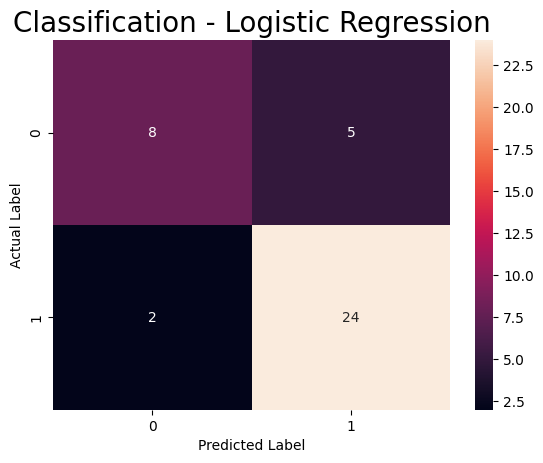

              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.83      0.92      0.87        26

    accuracy                           0.82        39
   macro avg       0.81      0.77      0.78        39
weighted avg       0.82      0.82      0.81        39



In [ ]:
clf=LogisticRegression()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
ax=sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='g')
plt.title('Classification - Logistic Regression', fontsize = 20)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()
print(classification_report(y_test,y_pred))

## Results

We are able to get 0.92 recall and 0.83 in this classifier. This means when the algorithm correctly identifies 92% of post-meal peaks.This is promising and much better than a random classifier that would get 0.65 given our dataset is roughly 65% positive (post-meal peak).

In this application I'd argue **we care most about recall**.

Recall - TP/(TP+FN).

The reason is we want to encourage the user to annotate as much of the data to have the best data quality. A false negative means we miss capturing that datapoint and it may be lost forever.

Precision is less important in this application.

Precision - TP/(TP+FP)

A false positive would mean the algorithm asks the user if there was a meal log they might have missed. This is annoying, but not as bad as false negative (lose data). With 0.83 precision, when the algorithm identifies a post-meal peak and asks the user to confirm, its right about 83% of the time, which isn't too shabby.

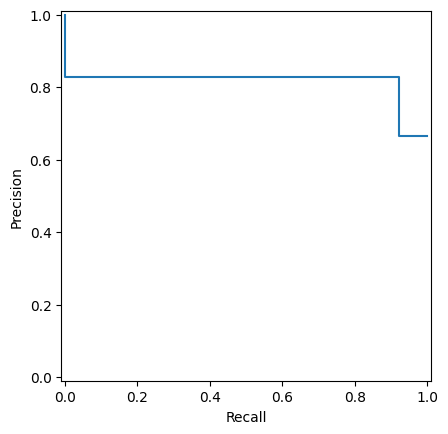

In [ ]:
#sanity check. we are just changing probability threshold to be considered a positive.
#at the right most end, the lowest threshold to be considered positive, we get roughly 65% precision, which aligns with earlier observations.

precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [ ]:
weights=clf.coef_[0]
for name, weight in zip(x_variables, weights):
    print(f"{name}: {weight:.4f}")

print(f"Intercept: {clf.intercept_[0]:.4f}")

glucose_max: 0.0044
glucose_min: 0.0238
glucose_auc: 0.0593
glucose_rate_rise: 0.0281
glucose_rate_fall: -0.0036
time_1: 0.1508
time_2: -0.3927
time_3: 0.2518
time_4: -0.8921
Intercept: -5.0536


Output of logistic regression for interpretation:

glucose_max: 0.0044
glucose_min: 0.0238
glucose_auc: 0.0593
glucose_rate_rise: 0.0281
glucose_rate_fall: -0.0036
time_1: 0.1508
time_2: -0.3927
time_3: 0.2518
time_4: -0.8921
Intercept: -5.0536


Most important factors:
- glucose_auc (mg/dL * hours)
- glucose_rate_rise (mg/dL/hours)
- timing.
  - time_0 is morning (6-10 am)
  - time_1 is noon (10-2 pm)
  - time_2 is afternoon (2-6 pm)
  - time_3 is evening (6-10 pm)
  - time_4 is midnight (10-6 am). any signal there is likely to be false. unless user is a late night snacker.

For every unit increase of glucose_auc, log odds of guessing positive (post_meal_peak) increases by 0.0593
For every unit increase of glucose_rate_rise, log odds of guessing positive (post_meal_peak) increases by 0.0281

## Conclusion
We were able to train a classifier (logistic regression) on our annoated glucose peak data set. We are able to get 0.92 recall and 0.83.

What this means:  This means when the algorithm correctly identifies 92% of post-meal peaks. This is promising and much better than a base rate of 0.65 (the rate a random classifier would achieve if it predicts 1 everytime) This could already be useable as a prototype tool to idenfity peaks and prompt users to log data.

The model can be improved with additional work. Additional features (such as within 2 hours of exercise) or (last meal event) could help distinguish between metabolic spikes and nutritional ones.

We could also examine the False negatives and False Positives to see if there are any contributing artifacts, such as sensor noise, or disconnects, etc. We may be able to utilize this info to help us improve our algorithm.

We could also try random forest or other more advanced algorithms, since there are likely nonlinear interactions happening (human physiology is complicated). The advantage may be more pronounced with a larger dataset.